**Rapid Diagnosis of IDC in Mammography Scans using Deep Learning**

“Breast cancer is the most common cancer in women and it is the main cause of death from cancer among women in the world.” (https://en.wikipedia.org/wiki/Mammography)

An Invasive Ductal Carcinoma is the most common form of breast cancer, according to John Hopkins Medicine 80% of all breast cancer diagnoses are IDC. This cancer subtype is a cancer that began growing in a milk duct and has invaded other breast tissues outside of the duct (https://www.hopkinsmedicine.org/breast_center/breast_cancers_other_conditions/invasive_ductal_carcinoma.html)

The goal of this work is to improve the early detection of cancer and the accuracy of the diagnosis. Getting more accurate results quicker.

The selected dataset is the “Breast Histopathology Images” found on Kaggle:
https://www.kaggle.com/paultimothymooney/breast-histopathology-images
The dataset contains folders with the digital mammography images, 198,738 IDC negative images (71.6%) and 78,786 IDC positive images (28.4%), which are going to be used to train (+ validate) and test the CNN.


** Running Instructions **

1) Install Anaconda and run Jupyter notebook server

2) Download the dataset from Kaggle (1.55GB): https://www.kaggle.com/paultimothymooney/breast-histopathology-images

3) Extract the dataset zip file in a directory acceissble by you notebook (--notebook-dir=<<my local dir>>)

4) Open the notebook, and Configure the "global settings" cell for your test:
- Optional: Set a working directory for the test: 'BASE_RUN_DIR = 'trained_models/04-09-2018/' #dd-MM-yyyy
- Set the input training dataset directory (where you extraced the Zip): TRAIN_DATA_DIR = 'IDC_regular_ps50_idx5/'
- Move (!!!) some of the input images from the TRAIN_DATA_DIR to a new directory and point the TEST_DATA_DIR to it: TEST_DATA_DIR = 'UNSEEN_DATA/'
- Set the number of images to load (e.g. 90000 images ~ 3.5 hours, 250K ~8 hours): MAX_NUM_IMAGES_TO_LOAD = 90000

5) Click Cell --> Run All


In [43]:
#Global Settings 
VERBOSE=1

#For testing and debugging use a small number of images - None means load ALL images (~270K)
MAX_NUM_IMAGES_TO_LOAD = None
#MAX_NUM_IMAGES_TO_LOAD = 70000

#Global labels definition for various plots
labels = {0:'IDC(-)',1:'IDC(+)'}

DEFAULT_TASK='full_cnn'

TRAIN_DATA_DIR = 'IDC_regular_ps50_idx5/'
TEST_DATA_DIR = 'UNSEEN_DATA/'
#change the date to create a new direotory for output files
#================================================#
BASE_RUN_DIR = 'trained_models/06-09-2018/' #dd-MM-yyyy
import os
if not os.path.exists(BASE_RUN_DIR):
    os.makedirs(BASE_RUN_DIR)
#================================================#

## Import required modules

In [2]:

import sys
from glob import glob
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import time
import itertools
import functools

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import class_weight

#keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l1,l2
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model # requires GraphViz installation apt-get install graphviz
from keras.utils import multi_gpu_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras import optimizers
from keras import applications
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Helper methods and utilities

In [3]:
def plot_image(image_path,title):
    """
    Plots an RGB image in size 50/50
    """
    image = cv2.imread(image_path)
    image = cv2.resize(image, (TARGET_IMG_WIDTH,TARGET_IMG_HEIGHT))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.figure()
    return

In [4]:
def images_to_nparray(input_image_paths_array):
    """
    Gets paths of *.png images, and returns two numpy parrays,
    X with the images data, and y with the labels (1D)
    """ 
    output_images_nparray=[]
    output_labels_nparray=[]
    index = 1
    total_images_to_load = len(input_image_paths_array)
    
    for img in input_image_paths_array:
        input_image = cv2.imread(img)
        output_images_nparray.append(cv2.resize(input_image, (TARGET_IMG_WIDTH,TARGET_IMG_HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img.endswith('class0.png'):
            output_labels_nparray.append(0)
        elif img.endswith('class1.png'):
            output_labels_nparray.append(1)
        else:
            raise Exception('All labeled images should end with with class0.png or class1.png - (got:{})'.format(img))            

        print('<<< Loading {}/{} >>>'.format(index,total_images_to_load),end='\r')
        index += 1
        if index%100 == 0:
            sys.stdout.flush()
    return np.array(output_images_nparray),np.array(output_labels_nparray)


## Custom Keras metrics: F1,Recall,Precision

Used to measure the performance of the trained model.
F1 score is more suitable than accuracy for measuring the model performance in cases of imbalanced dataset:

*Precision = TP / TP + FP*
Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is: of all patients labeled as IDC(+) or IDC(-), how many are actually IDC(+) or IDC(-)?

*Recall = TP/TP+FN*
Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the patients that actually IDC(+) or IDC(-), how many did we label as IDC(+) or IDC(-)

*F1 Score = 2*(Recall * Precision) / (Recall + Precision)*
"F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall."

Reference: http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

In [5]:
#The following code snippet is based on the following Keras issue:
#https://github.com/keras-team/keras/issues/5400
#related to custom F1,Precision and Recall methods in Keras

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
    return precision+K.epsilon()

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision
    
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Visualization Methods

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize==True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.rcParams['figure.figsize'] = (6,4)

    plt.show()

    
def print_confusion_matrix(y_true,y_pred_classes):
    confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
    
    #not normalized
    #plot_confusion_matrix(confusion_mtx, classes = list(labels.values())) 
    
    #normalized
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()),normalize=True) 


*Exlore the images data*

In [7]:
def load_images_from_path(path):
    """
    This is used in data exploration to print basic statistics about the labeled images from a given path. 
    """
    images = glob(path + '/**/*.png', recursive=True)
    len_total_images = len(images)
    print('Total number of images {}'.format(len_total_images))

    idc_negative_images = glob(path + '/*/0/*.png', recursive=True)
    len_idc_negative = len(idc_negative_images)
    print('Total number of {} images {}'.format(labels[0],len_idc_negative))

    idc_positive_images = glob(path + '/*/1/*.png', recursive=True)
    len_idc_positive = len(idc_positive_images)
    print('Total number of {} images {}'.format(labels[1],len_idc_positive))

    #Make sure we didn't lose any image
    assert len_total_images  == len_idc_negative + len_idc_positive 

    idc_negative_precentage = len_idc_negative / len_total_images
    print('Precentage of {} images {:.2f}%'.format(labels[0],idc_negative_precentage*100))

    idc_positive_precentage = len_idc_positive / len_total_images
    print('Precentage of {} images {:.2f}%'.format(labels[1],idc_positive_precentage*100))
    
    plt.clf()
    # Data to plot
    sizes = [len_idc_negative,len_idc_positive]
    colors = ['lightcoral', 'yellowgreen']
    explode = (0, 0)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()
    
    #Plot sample images
    plt.clf()
    
    #IDC Negative sample
    rnd_int = random.randint(1,len_idc_negative)
    idc_neg_image_path = idc_negative_images[rnd_int] 

    title = '{} image sample:\n({}) '.format(labels[0],idc_neg_image_path)
    plt.subplot(1,2,1)
    plot_image(image_path=idc_neg_image_path,title=title)

    ##IDC Positive sample
    rnd_int2 = random.randint(1,len_idc_positive)
    idc_pos_image_path = idc_positive_images[rnd_int2] 
    
    plt.subplot(1,2,2)    
    title = '{} image sample:\n({}) '.format(labels[1],idc_pos_image_path)
    plot_image(image_path=idc_pos_image_path,title=title)
    
    return images

In [8]:
def summarize_kfold(cvsscores):
    """
    Summarize the cross validation scores at the end of every fold.
    It prints a summary of the measured metrics using a pandas dataframe describe()
    """
    df = pd.DataFrame(cvsscores)
    for metric in df[1].unique():
        df2 = df.loc[df[1] == metric]
        df3 = df2.drop(0,axis=1)
        print('{}:'.format(metric))
        #print(df3.describe())
        print('\n================')

In [9]:
def plot_kfold_summary(cvsscores,timestamp=None):
    """
    Plots a line chart with all the measured metrics at the end of the training evaluation
    It is not a learning curve plot, just a 'score per fold' printout
    """
    plt.clf()
    plt.rcParams['figure.figsize'] = (10,4)
    
    if timestamp == None:
        timestamp = str(time.time())
    
    #plot metrics except for loss and acc
    loss_acc = ['loss','acc']
    df = pd.DataFrame(cvsscores)
    metrics_list = df[1].unique()
    
    #plt.rcParams['figure.figsize'] = (3.0, 3.0)
    #plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.subplots(nrows=1,ncols=2)
    plt.subplot(1, 2, 1)
    plt.title('F1 Recall Precision Across Folds')
    plt.xlabel('Fold #')
    plt.ylabel('metric')
    for metric in metrics_list:
        if metric not in loss_acc:
            df2 = df.loc[df[1] == metric]
            l = df2[2].tolist()
            plt.plot(l, label=metric)
            
    plt.legend()

    # save the figure
    #plt.savefig('./training_learning_curves_'+timestamp+'.png')
    #plt.rcParams['figure.figsize'] = (3.0, 3.0)
    #plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.subplot(1, 2, 2)
    plt.title('Loss Acc Across Folds')
    plt.xlabel('Fold #')
    plt.ylabel('metric')
    for metric_ in metrics_list:
        if metric_ in loss_acc:
            df2 = df.loc[df[1] == metric_]
            l_ = df2[2].tolist()
            plt.plot(l_, label=metric_)
        
    plt.legend()
    plt.show()
    


In [10]:
def plot_learning_curve_single(history,metric_list,rows,columns,fig_number,fold):
    
    plt.subplot(rows, columns, fig_number)
    
    for metric in metric_list:
        plt.plot(history.history[metric])
    plt.legend(metric_list,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
    plt.xlabel('epochs-fold#'+fold)
    
def plot_learning_curves(history_list):
    # Plot Multiple Images
    h = 0
    fig_num = 1
    columns = 5 #f1, acc , loss
    rows = len(history_list)
    F1_ = 'f1'
    PRECISION_ = 'precision'
    RECALL_ = 'recall'
    ACC_ = 'acc'
    LOSS_ = 'loss'
        
    plt.rcParams['figure.figsize'] = (15,rows*3)
    #plt.subplots(nrows=rows,ncols=columns)
    plt.subplots_adjust(wspace=0.6, hspace=1)
    
    for history in history_list:
        #create plot images for histories
        #print('*** FOLD #{} ***'.format(h))
        plot_learning_curve_single(
            history,[ACC_,'val_'+ACC_],rows,columns,fig_num,str(h))
        fig_num += 1
        plot_learning_curve_single(
            history,[LOSS_,'val_'+LOSS_],rows,columns,fig_num,str(h))
        fig_num += 1
        plot_learning_curve_single(
            history,[F1_,'val_'+F1_],
            rows,columns,fig_num,str(h))
        fig_num += 1
        plot_learning_curve_single(
            history,[PRECISION_,'val_'+PRECISION_],
            rows,columns,fig_num,str(h))
        fig_num += 1
        plot_learning_curve_single(
            history,[RECALL_,'val_'+RECALL_],
            rows,columns,fig_num,str(h))
        fig_num += 1
        h+=1
    plt.show()
        
    plt.clf()

## Keras 

In [11]:
def get_image_generators(X_train,y_train,X_valid,y_valid,batch_size = 32,task=DEFAULT_TASK):
    """
    Create train and validation generators 
    The train one is with data Augumentation , the validation is untouched (just flowing the images)
    """
    if task=='benchmark':
        train_datagen = ImageDataGenerator()

        train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size = batch_size)
    else:
        train_datagen = ImageDataGenerator(
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = "nearest",
            zoom_range = 0.2,
            width_shift_range = 0.2,
            height_shift_range=0.2,
            rotation_range=25)

        train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size = batch_size,shuffle=True)
        
    valid_datagen = ImageDataGenerator()
    validation_generator = valid_datagen.flow(
        X_valid, y_valid)
    
    return train_generator, validation_generator
    

In [12]:
def get_train_class_weights(y_train):
    """
    Return the training dataset class weights - to be used in the training when calling fit_generator()
    """
    train_class_weight = class_weight.compute_class_weight('balanced',
                                                           np.unique(y_train),
                                                           y_train)
    #print('Train Class Weights: {}'.format(train_class_weight))
    return train_class_weight

*Benchmark Model CNN Architechture*

A very simple CNN with 1 Convolutional 2D layer (the Input) and 1 output Dense layer.
- The Input layer is a Conv2D layer, with activation of 'relu', that accepts the images in shape 50X50X3
- The output Dense layer is of size 2 (2 classes) with activation 'softmax' that matches a multiclass scenario, it outputs the probability of the each class of the two classes: IDC(-) and IDC(+)


In [13]:
def get_benchmark_model():
    """
    Build a benchmark model for showing the problem is solveable using a very simple naive CNN
    """
    benchmark_model = Sequential()
    benchmark_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    benchmark_model.add(Flatten())
    benchmark_model.add(Dense(2, activation='softmax'))

    benchmark_model.compile(loss='categorical_crossentropy',
            #optimizer='rmsprop',
            optimizer = optimizers.Adam(lr=0.0001),#to intentionally Overfit
            metrics=['accuracy',f1,recall,precision])
    return benchmark_model


*Full CNN Architechture*

Transfer Learning from a pretrained VGG19 network based on imagenet, without the top layers.
The first 6 basic layers of the VGG19 are frozen - the model will not be trained on them.

- The Input layer accepts the images in shape 50X50X3
- The rest of  hidden layers except for the last 5 are the VGG19, without the top layer.
- Adding 2 Dense layers of size 128 with activation 'relu' with Dropout to reduce overfitting
- The output layer is of size 2 (2 classes) with activation 'softmax' that matches a multiclass scenario, it outputs the probability of the each class of the two classes: IDC(-) and IDC(+)

Note: I added an option to train on multi_gpu - though in my tests the performanc was not better


In [38]:
def get_full_cnn_model(use_multi_gpu=False,
                       optimizer_key='SGD',learn_rate=0.0001,momentum_value=0.9):
    """
    Build a CNN based on the VGG19 architechture, with the 'imagenet' weights, without the top layers.
    """
    opt = available_optimizers[optimizer_key]
    try:
        optimizer=opt(lr=learn_rate, momentum=momentum_value)
    except:
        optimizer=opt(lr=learn_rate)

    
    model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = input_shape)

    # Freeze the first 6 layers which I don't want to train
    for layer in model.layers[:6]:
        layer.trainable = False


    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(128, activation="relu",kernel_regularizer=l2(0.01))(x) #activation
    x = BatchNormalization()(x) #normalization
    x = Dropout(0.4)(x)
    x = Dense(128, activation="relu")(x)
    predictions = Dense(2,activation="softmax")(x) 
                       

    # creating the final model 
    model_final = Model(inputs = model.input, outputs = predictions)
    if use_multi_gpu == True:
        try:
            model_final = multi_gpu_model(model_final)
        except:
            pass
    # compile the model 
    model_final.compile(loss = 'categorical_crossentropy',
                        #optimizer=optimizer,
                        #optimizer=optimizers.Adam(0.001), 
                        optimizer = optimizers.SGD(lr=0.001, momentum=0.9,nesterov=True), #0.00001 was Best F1_score !!!
                        metrics=['accuracy',f1,recall,precision])

    return model_final


In [15]:
def get_callbacks(epochs):
    """
    Callbacks for saving the trained model checkpoints, and early stopping if learning is not progressing
    """
    # Save the model according to the conditions  
    checkpoint = ModelCheckpoint('checkpoint_vgg19.h5', monitor='val_loss', verbose=VERBOSE,
                             save_best_only=True, save_weights_only=False, mode='auto')
    early = EarlyStopping(monitor='val_loss', patience=epochs-int(epochs*0.2), verbose=VERBOSE, mode='auto')
    return [checkpoint,early]

In [16]:

#Grid Search in KERAS for hyperparameters tuning
available_optimizers = {'SGD' : optimizers.SGD,
                                'RMSprop' : optimizers.RMSprop,
                                'Adadelta' : optimizers.Adadelta,
                                'Adam' : optimizers.Adam}
def do_grid_search(X_trn,y_trn):
    """
    Perform GridSearch CV for Hyperparameters tuning (there is an option to use it when running the full_cnn training)
    """
    VERB = 0
    # create model
    model = KerasClassifier(build_fn=get_full_cnn_model, verbose=VERB)#, epochs=10, batch_size=50,
    # define the grid search parameters
    #optimizer_key = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
    optimizer_key = ['SGD', 'Adadelta']

    # Use scikit-learn to grid search 
    #activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
    momentum_value = [0.2,0.5]
    learn_rate = [0.0001,0.001]
    epochs = [10,15] #, 100, 150 etc
    batch_size = [50, 100] # add 5, 10, 20, 40, 60, 80, 100 etc

    param_grid = dict(epochs=epochs,
                      batch_size=batch_size,
                      optimizer_key=optimizer_key,
                      learn_rate=learn_rate,
                      momentum_value=momentum_value)
    ##############################################################
    grid = GridSearchCV(estimator=model, param_grid=param_grid,verbose=VERB)# n_jobs=1
    grid_result = grid.fit(X_trn, y_trn,verbose=VERB)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_estimator_
#After Grid Search on 9000 images
#Best: 0.859222 using {'batch_size': 50, 'epochs': 10, 'learn_rate': 0.0001, 'momentum_value': 0.2, 'optimizer_key': 'SGD'}

#####################################################################################

In [17]:
def run_training_evaluation(X,y,task=DEFAULT_TASK,n_splits=10,
                            batch_size=32,epochs=10,verbose=VERBOSE,
                            timestamp=None,model_save_path=None,grid_search=False):
    """
    Train a model using Cross Validation KFold to split the dataset.
    """
    # define 10-fold cross validation test harness
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    best_cvscores = []
    history_list = []
    i = 0
    max_val_f1 = -1.0

    if timestamp == None:
        timestamp = str(time.time())

    start_time = time.time()
    print('{} folds - {} epochs -  Starting training on {}/{} images (batch_size={})'.format(
        n_splits,epochs,len(X),NUM_OF_IMAGES_TO_LOAD,batch_size))

    # create model
    if task=='benchmark':
        model = get_benchmark_model()
    elif task == 'full_cnn':
        model = get_full_cnn_model()
    else:
        print('Please specify a task either benchmark or full_cnn')
        return

           
    if grid_search == True:
        print('<<< Running GRID-SEARCH >>>')
        model = do_grid_search(X_trn=X, y_trn=y)
        
    for train, test in kfold.split(X, y):
       
        fold_start_time = time.time()
        print('>>> Fold {} started<<<'.format(i))
        
        y_hot = to_categorical(y,2)

        train_generator, validation_generator = get_image_generators(
            X[train],y_hot[train],X[test],y_hot[test],task=task)

        #Perform Grid Search Only
        if grid_search == True:
            history_ft = model.fit(
                X[train],y_hot[train],
                epochs = epochs,
                #steps_per_epoch=int(len(X[train])/batch_size),
                validation_data = (X[test],y_hot[test]),
                class_weight=get_train_class_weights(y[train]),
                callbacks = get_callbacks(epochs),
                verbose=verbose)
            
        #Train and Evaluate the model 
        else:
            history_ft = model.fit_generator(
                train_generator,
                epochs = epochs,
                steps_per_epoch=int(len(X[train])/batch_size),
                validation_data = validation_generator,
                class_weight=get_train_class_weights(y[train]),
                callbacks = get_callbacks(epochs),
                verbose=verbose)
        
            # evaluate the model
            scores = model.evaluate_generator(validation_generator,verbose=verbose)
            print('Model evaluation:')
            for score in range(0, len(scores)):
                #print('{}={:.4f}'.format(model.metrics_names[score],scores[score]),sep='')
                #save a tuple: (fold#,metric name, metric value)
                best_cvscores.append((i,model.metrics_names[score],scores[score]))
            i+=1

        history_list.append(history_ft)

        if scores[2] > max_val_f1:
            #best_history = (i,history_ft)
            max_val_f1 = scores[2]
            model.save(model_save_path)
            print('Saving new model {} -  Max {}={:.9f}'.format(model_save_path,model.metrics_names[2],scores[2]))

        else:
            print('Not saving F1 ...as  {} < {}'.format(scores[2],max_val_f1))
        fold_end_time = time.time()
        print('<<< Fold completed in {} minutes >>>'.format(int((fold_end_time-fold_start_time)/60)))    

          
    end_time = time.time()
    print('######## Model was fitted on {} train images in {:.2f} minutes'.format(len(X),int(end_time-start_time)/60))
    print('>>>>>>>> Max F1 score across all Folds:{:.9f}'.format(max_val_f1))
    
    return best_cvscores,history_list

In [18]:
def plot_25_samples(fewImages):
    """
    Reference: https://www.kaggle.com/paultimothymooney/predict-idc-in-breast-cancer-histology-images
    """
    #plt.clf()
    rnd_number = random.randint(1,len(fewImages))
    location = 0
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for img_path in fewImages[rnd_number:rnd_number+25]:
        im = cv2.imread(img_path)
        im = cv2.resize(im, (50, 50)) 
        plt.subplot(5, 5, location+1)
        plt.title(rnd_number+location)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        location += 1

*Data Exploration*

Total number of images 256396
Total number of IDC(-) images 183957
Total number of IDC(+) images 72439
Precentage of IDC(-) images 71.75%
Precentage of IDC(+) images 28.25%


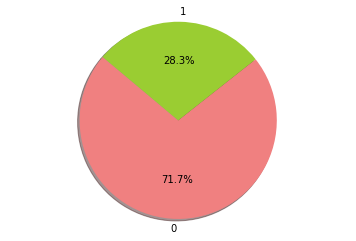

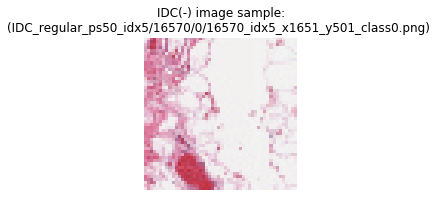

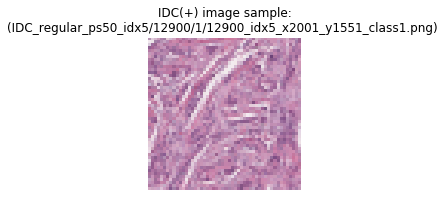

<Figure size 432x288 with 0 Axes>

In [19]:
plt.clf()
TARGET_IMG_WIDTH = 50
TARGET_IMG_HEIGHT = 50
input_shape = (TARGET_IMG_WIDTH,TARGET_IMG_HEIGHT, 3)

#Data exploration - train 

loaded_training_images_paths = load_images_from_path(TRAIN_DATA_DIR)

Total number of images 21128
Total number of IDC(-) images 14781
Total number of IDC(+) images 6347
Precentage of IDC(-) images 69.96%
Precentage of IDC(+) images 30.04%


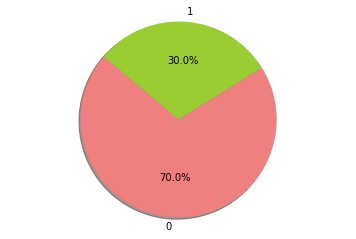

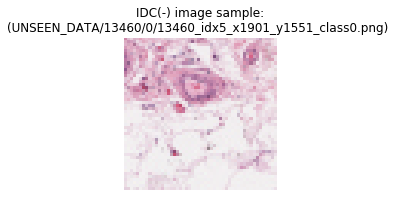

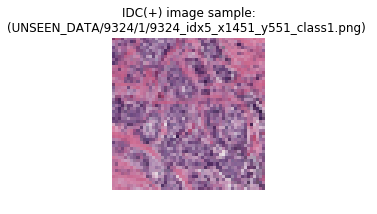

<Figure size 432x288 with 0 Axes>

In [20]:
#Data exploration - test 
test_images_paths = load_images_from_path(TEST_DATA_DIR)

25 sample images of IDC negative


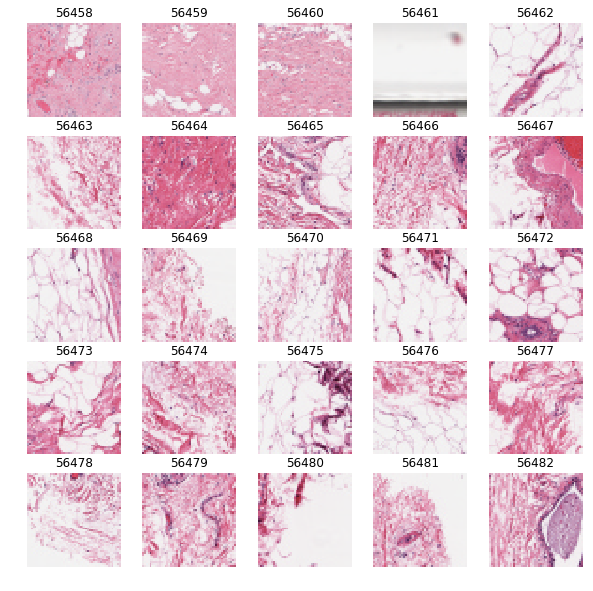

In [21]:
# Plot few sample IDC(-) images
few_IDC_neg_images = glob(TRAIN_DATA_DIR + '*/0/*.png', recursive=True)

print('25 sample images of IDC negative')
plot_25_samples(few_IDC_neg_images)

25 sample images of IDC positive


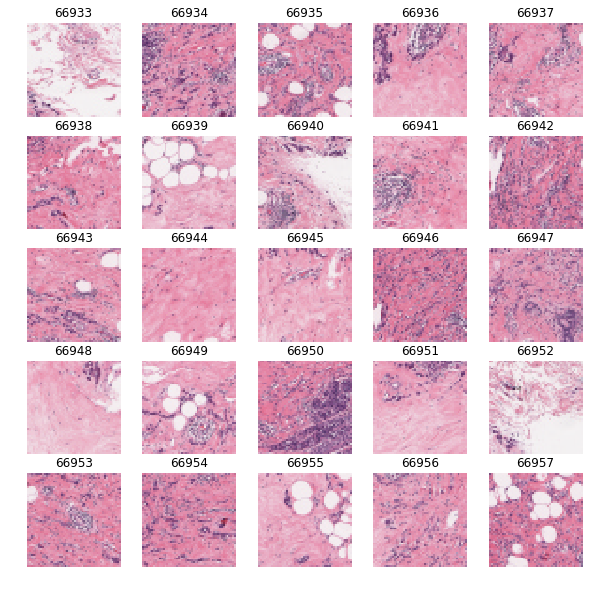

In [22]:
# Plot few sample IDC(+) images

few_IDC_pos_images = glob(TRAIN_DATA_DIR+'*/1/*.png', recursive=True)

print('25 sample images of IDC positive')
plot_25_samples(few_IDC_pos_images)

*Perform a benchmark model - a simple CNN*

In [23]:
#Runs the benchmark model training and evaluation
#set the numbers epochs,folds and batch_size
def run_benchmark(task='benchmark',model_save_path=None,ts=None):
    batch_size = 50 
    epochs = 10
    folds = 7
    #use_multi_gpu=True
    bm_scores,bm_hist_list = run_training_evaluation(
        X,y,task=task,n_splits=folds,batch_size=batch_size,
        epochs=epochs,verbose=VERBOSE,timestamp=ts,model_save_path=model_save_path)
    return bm_scores,bm_hist_list

*Transfer Learning from VGG19 pretrained on 'imagenet*

In [46]:
#Runs the benchmark model training and evaluation
#set the numbers epochs,folds and batch_size

def run_full_cnn(task='full_cnn',model_save_path=None,ts=None,grid_search=False):
    batch_size = 50 
    epochs = 10
    folds = 7
    #use_multi_gpu=True
    fn_scores,fn_hist_list = run_training_evaluation(
        X,y,task=task,n_splits=folds,batch_size=batch_size,
        epochs=epochs,verbose=VERBOSE,timestamp=ts,model_save_path=model_save_path,
        grid_search=grid_search)
    return fn_scores,fn_hist_list

In [25]:
def test_on_unseen_data(model_file_save_path=None,test_dataset_paths=None):
    """
    This function runs on the UNSEEN data directory that holds around 20,000 unseen images, it is used
    as an additional model evaluation technique, and produces a confusion matrix with the predictions 
    """
    if model_file_save_path == None:
        print('No model path provided'.format(model_file_save_path))
        return
    #Load the trained model

    model = load_model(model_file_save_path,custom_objects={'f1': f1,'recall':recall,'precision':precision})

    plt.clf()
    
    #Load test images (unseen data)
    X_tt = None
    y_tt = None

    NUM_OF_TST_IMAGES_TO_LOAD = len(test_dataset_paths)
    
    #Load the model
    print('Loading {} test images...'.format(NUM_OF_TST_IMAGES_TO_LOAD))
    start_time = time.time()
    X_tt,y_tt = images_to_nparray(test_dataset_paths[0:NUM_OF_TST_IMAGES_TO_LOAD])
    print(len(X_tt))
    print(len(y_tt))
    end_time = time.time()
    print('{} test images were loaded - in {:.2f} seconds'.format(NUM_OF_TST_IMAGES_TO_LOAD,end_time-start_time))

    #Evaluate the model
    batch_size=50
    num_of_test_samples=len(X_tt)
    test_datagen = ImageDataGenerator()
    y_tt_hot = to_categorical(y_tt,2)
    test_generator = test_datagen.flow(
        X_tt, y_tt_hot)

    results = model.evaluate_generator(test_generator,verbose=1)
    print('*** Model evaluation on testing data:***')
    #print(model.metrics_names)
    [(i,print('{}={:.9f}'.format(model.metrics_names[i],result))) for (i,result) in enumerate(results)]

  
    #predict on UNSEEN DATA 
    print('*** Model classes prediction on testing data:***')
    #Confution Matrix and Classification Report
    Y_pred = model.predict(X_tt,verbose=1)
    Y_pred_classes = Y_pred.argmax(axis=-1)

    print('*** Classification Report ***')
    target_names = list(labels.values())
    print(classification_report(y_tt,
                                Y_pred_classes,
                                target_names=target_names))
    
    
    #plt.clf()
    print('*** Confusion Matrix ***')
    print_confusion_matrix(y_tt, Y_pred_classes)

In [26]:
#####################################################################################

In [44]:
#Loading images (takes around 3 minutes minutes for the full dataset!!!!!!)

X = None
y = None

#limit the number of images used for training
if MAX_NUM_IMAGES_TO_LOAD != None:
    NUM_OF_IMAGES_TO_LOAD = MAX_NUM_IMAGES_TO_LOAD
else:
    NUM_OF_IMAGES_TO_LOAD = len(loaded_training_images_paths)

print('Loading {} images...'.format(NUM_OF_IMAGES_TO_LOAD))
start_time = time.time()
X,y = images_to_nparray(loaded_training_images_paths[0:NUM_OF_IMAGES_TO_LOAD])
end_time = time.time()
print('{} images were loaded - in {:.2f} seconds'.format(NUM_OF_IMAGES_TO_LOAD,end_time-start_time))

Loading 256396 images...
256396 images were loaded - in 69.60 seconds


In [28]:
#####################################################################################


In [29]:
#Benchmark
bm_timestamp = str(time.time())
task = 'benchmark'
get_benchmark_model().summary()
#Saving the model architechture graph as an image
#plot_model(get_benchmark_model(),show_layer_names=False,to_file=task + '_model.png')

bm_model_file_name = BASE_RUN_DIR + task + '_' + bm_timestamp + '.model'
bm_scores_,bm_hist_list_=run_benchmark(task=task,model_save_path=bm_model_file_name,ts=bm_timestamp)

print('Benchmark model saved:{}'.format(bm_model_file_name))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 294914    
Total params: 296,706
Trainable params: 296,706
Non-trainable params: 0
_________________________________________________________________
7 folds - 10 epochs -  Starting training on 70000/70000 images (batch_size=50)
>>> Fold 0 started<<<
Epoch 1/10
1199/1199 [==============================] - 7s 6ms/step - loss: 4.7526 - acc: 0.7051 - f1: 2.3107e-08 - recall: 1.1553e-08 - precision: 1.0000 - val_loss: 4.7576 - val_acc: 0.7048 - val_f1: 2.3009e-08 - val_recall: 1.1505e-08 - val_precision: 1.0000

Epoch 00001: val_loss improved from 

1200/1200 [==============================] - 5s 4ms/step - loss: 4.7502 - acc: 0.7053 - f1: 2.3053e-08 - recall: 1.1526e-08 - precision: 1.0000 - val_loss: 4.7581 - val_acc: 0.7048 - val_f1: 2.3236e-08 - val_recall: 1.1618e-08 - val_precision: 1.0000

Epoch 00003: val_loss did not improve from 4.75806
Epoch 4/10
1200/1200 [==============================] - 5s 4ms/step - loss: 4.7788 - acc: 0.7035 - f1: 2.2795e-08 - recall: 1.1398e-08 - precision: 1.0000 - val_loss: 4.7581 - val_acc: 0.7048 - val_f1: 2.3063e-08 - val_recall: 1.1531e-08 - val_precision: 1.0000

Epoch 00004: val_loss did not improve from 4.75806
Epoch 5/10
1200/1200 [==============================] - 5s 4ms/step - loss: 4.7502 - acc: 0.7053 - f1: 2.3185e-08 - recall: 1.1593e-08 - precision: 1.0000 - val_loss: 4.7581 - val_acc: 0.7048 - val_f1: 2.3287e-08 - val_recall: 1.1643e-08 - val_precision: 1.0000

Epoch 00005: val_loss did not improve from 4.75806
Epoch 6/10
1200/1200 [==============================] - 5s 4ms/step -

1200/1200 [==============================] - 5s 4ms/step - loss: 4.7679 - acc: 0.7042 - f1: 2.3019e-08 - recall: 1.1510e-08 - precision: 1.0000 - val_loss: 4.7581 - val_acc: 0.7048 - val_f1: 2.3105e-08 - val_recall: 1.1553e-08 - val_precision: 1.0000

Epoch 00007: val_loss did not improve from 4.75806
Epoch 8/10
1200/1200 [==============================] - 5s 4ms/step - loss: 4.7066 - acc: 0.7080 - f1: 2.3403e-08 - recall: 1.1702e-08 - precision: 1.0000 - val_loss: 4.7581 - val_acc: 0.7048 - val_f1: 2.3152e-08 - val_recall: 1.1576e-08 - val_precision: 1.0000

Epoch 00008: val_loss did not improve from 4.75806
Epoch 9/10
1200/1200 [==============================] - 5s 4ms/step - loss: 4.7536 - acc: 0.7051 - f1: 2.3026e-08 - recall: 1.1513e-08 - precision: 1.0000 - val_loss: 4.7581 - val_acc: 0.7048 - val_f1: 2.3463e-08 - val_recall: 1.1732e-08 - val_precision: 1.0000

Epoch 00009: val_loss did not improve from 4.75806
Epoch 10/10
1200/1200 [==============================] - 5s 4ms/step 

313/313 [==============================] - 1s 2ms/step
Model evaluation:
Not saving F1 ...as  2.3171309705411036e-08 < 2.408372662898728e-08
<<< Fold completed in 0 minutes >>>
######## Model was fitted on 70000 train images in 5.72 minutes
>>>>>>>> Max F1 score across all Folds:0.000000024
Benchmark model saved:trained_models/06-09-2018/benchmark_1536405426.3274102.model


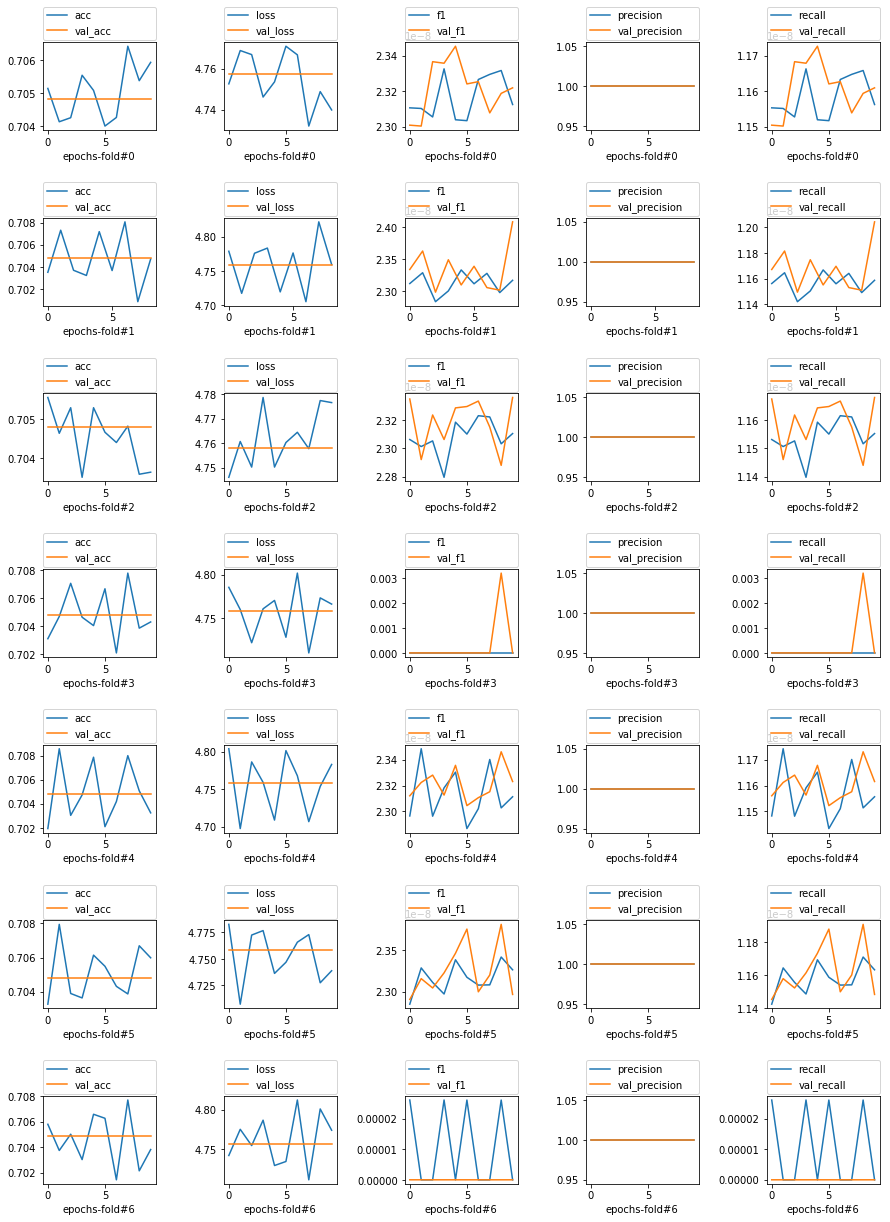

<Figure size 1080x1512 with 0 Axes>

In [30]:
#Plot training learning curves of epochs per fold
plot_learning_curves(bm_hist_list_)

<Figure size 1080x1512 with 0 Axes>

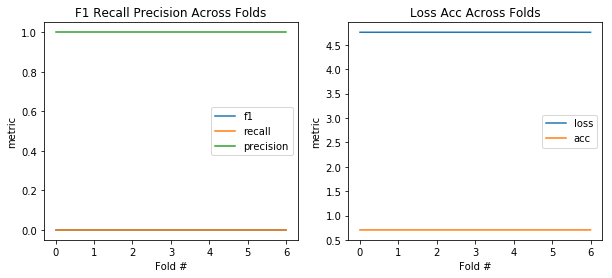

In [31]:
#Print a summary of the training process per Fold
plot_kfold_summary(bm_scores_)

Loading 21128 test images...
21128oading 21128/21128 >>>
21128
21128 test images were loaded - in 4.58 seconds
661/661 [==============================] - 1s 2ms/step
*** Model evaluation on testing data:***
loss=4.841989404
acc=0.699592957
f1=0.000000023
recall=0.000000011
precision=1.000000119
*** Model classes prediction on testing data:***
21128/21128 [==============================] - 1s 51us/step
*** Classification Report ***
             precision    recall  f1-score   support

     IDC(-)       0.70      1.00      0.82     14781
     IDC(+)       0.00      0.00      0.00      6347

avg / total       0.49      0.70      0.58     21128

*** Confusion Matrix ***
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


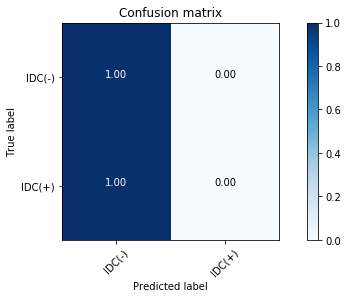

In [32]:
#Test Benchmark on UNSEEN data
test_on_unseen_data(model_file_save_path=bm_model_file_name,test_dataset_paths=test_images_paths)

In [33]:
#####################################################################################

In [47]:
#Full CNN

VERBOSE=1
fn_timestamp = str(time.time())
#task name (do not change)
task = 'full_cnn'
#Run GridSearch ? or only training with default hyperparameters
GS=False

#get_full_cnn_model().summary()
#Saving the model architechture graph as an image
#plot_model(get_full_cnn_model(),show_layer_names=False,to_file=task + '_model.png')

fn_model_file_name = BASE_RUN_DIR + task + '_' + fn_timestamp + '.model'
fn_scores_,fn_hist_list_=run_full_cnn(task=task,model_save_path=fn_model_file_name,ts=fn_timestamp,grid_search=GS)
print('Full CNN model saved:{}'.format(fn_model_file_name))

3 folds - 10 epochs -  Starting training on 256396/256396 images (batch_size=50)
>>> Fold 0 started<<<
Epoch 1/10
3418/3418 [==============================] - 93s 27ms/step - loss: 1.8418 - acc: 0.8449 - f1: 0.7101 - recall: 0.7149 - precision: 0.7348 - val_loss: 1.8458 - val_acc: 0.7905 - val_f1: 0.7018 - val_recall: 0.9121 - val_precision: 0.5831

Epoch 00001: val_loss improved from inf to 1.84583, saving model to checkpoint_vgg19.h5
Epoch 2/10
3418/3418 [==============================] - 91s 27ms/step - loss: 1.0991 - acc: 0.8588 - f1: 0.7422 - recall: 0.7472 - precision: 0.7637 - val_loss: 0.6708 - val_acc: 0.8694 - val_f1: 0.7671 - val_recall: 0.8061 - val_precision: 0.7520

Epoch 00002: val_loss improved from 1.84583 to 0.67084, saving model to checkpoint_vgg19.h5
Epoch 3/10
3418/3418 [==============================] - 91s 27ms/step - loss: 0.5167 - acc: 0.8644 - f1: 0.7463 - recall: 0.7471 - precision: 0.7732 - val_loss: 0.4650 - val_acc: 0.8128 - val_f1: 0.7247 - val_recall: 0.


Epoch 00004: val_loss improved from 0.29453 to 0.29227, saving model to checkpoint_vgg19.h5
Epoch 5/10
3418/3418 [==============================] - 91s 27ms/step - loss: 0.3116 - acc: 0.8872 - f1: 0.7906 - recall: 0.7945 - precision: 0.8115 - val_loss: 0.3295 - val_acc: 0.8769 - val_f1: 0.7565 - val_recall: 0.7197 - val_precision: 0.8244

Epoch 00005: val_loss did not improve from 0.29227
Epoch 6/10
3418/3418 [==============================] - 90s 26ms/step - loss: 0.2985 - acc: 0.8856 - f1: 0.7883 - recall: 0.7922 - precision: 0.8094 - val_loss: 0.2958 - val_acc: 0.8854 - val_f1: 0.7689 - val_recall: 0.7236 - val_precision: 0.8474

Epoch 00006: val_loss did not improve from 0.29227
Epoch 7/10
3418/3418 [==============================] - 90s 26ms/step - loss: 0.2854 - acc: 0.8846 - f1: 0.7870 - recall: 0.7917 - precision: 0.8076 - val_loss: 0.2984 - val_acc: 0.8848 - val_f1: 0.7734 - val_recall: 0.7405 - val_precision: 0.8339

Epoch 00007: val_loss did not improve from 0.29227
Epoch 8

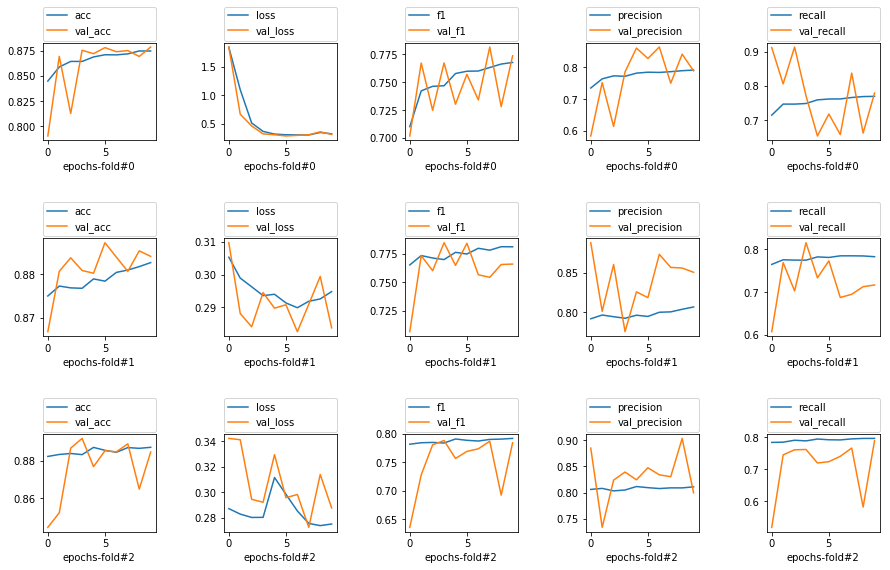

<Figure size 1080x648 with 0 Axes>

In [48]:
#Plot training learning curves of epochs per fold
plot_learning_curves(fn_hist_list_)

<Figure size 1080x648 with 0 Axes>

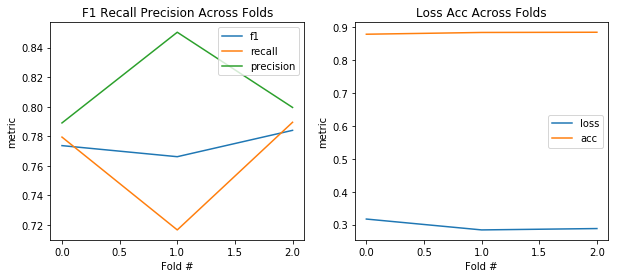

In [49]:
#Print a summary of the training process
plot_kfold_summary(fn_scores_)

Loading 21128 test images...
21128oading 21128/21128 >>>
21128
21128 test images were loaded - in 4.40 seconds
661/661 [==============================] - 5s 8ms/step
*** Model evaluation on testing data:***
loss=0.356086021
acc=0.836520257
f1=0.685470528
recall=0.633678991
precision=0.782006743
*** Model classes prediction on testing data:***
21128/21128 [==============================] - 5s 237us/step
*** Classification Report ***
             precision    recall  f1-score   support

     IDC(-)       0.85      0.92      0.89     14781
     IDC(+)       0.78      0.64      0.70      6347

avg / total       0.83      0.84      0.83     21128

*** Confusion Matrix ***
Normalized confusion matrix
[[0.92287396 0.07712604]
 [0.36458169 0.63541831]]


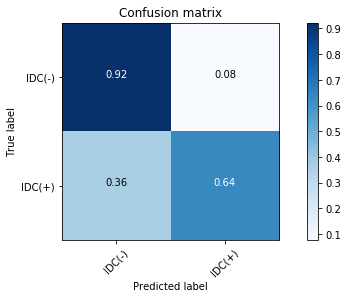

In [50]:
#test_images_paths = load_images_from_path(TEST_DATA_DIR)
#model_file='trained_models/30-08-2018/full_cnn_1535866608.354061.model'
test_on_unseen_data(model_file_save_path=fn_model_file_name,test_dataset_paths=test_images_paths)
#Test CNN on UNSEEN data
#test_on_unseen_data(model_file_save_path=fn_model_file_name,test_dataset_paths=test_images_paths)

In [ ]:
#Last : optimizer = optimizers.SGD(lr=0.001, momentum=0.9,nesterov=True), 2 folds, ~250K images 10 epochs